## Classification with CNN
- Dataset: Steam reviews (Steam.csv)
- 2990 labeled game reviews
- Performance is greater than 80%. The recall score is better improved.
- The CNN model is performed as following:
  - Using pretrained word vectors:
    - Obtained by train Word2Vec/Doc2Vec model
      - We will check the word similarity to choose the best performance word vectors trained         from word2vec and doc2vec    
    - Mapping the word with vacabulary and creating embedding matrix
    - Set embedding layer with the embedding matrix 
  - Tuning hyperparameter through sample lengh and word frequency counting
  - Filters in three size:
    - bigram (ConvID, kernel_size = 2)
    - trigram (ConvID, kernel_size = 3)
    - quadrigram (ConvID, kernel_size = 4)
  - Max pooling
  - Regularization: Dropout
  - Max Epochs: 100, early stop before the accuracy of validation steeply drop down

## Conclusion
- **The CNN extracted features by different size filters indirectly consider the semantics of the words has a better performance in classification compared with NB and SVM models.**
- **The CNN model has a benchmark of an accuracy more than 80%.**
- **The pretrained matrix set at embedding layer, training by doc2vec consider the paragraph vector in predicting next word, has improved the model.**

In [1]:
import pandas as pd
import re
import warnings
import nltk,string
from gensim.models import word2vec
import logging
import matplotlib.pyplot as plt
from gensim.models.doc2vec import TaggedDocument
from random import shuffle
from gensim.models import doc2vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# load 19900 unlabeled data to train word2vec and doc2vec
df = pd.read_csv('steam.csv')
df['user_reviews'] = df['user_reviews'].apply(\
                        lambda row: ' '.join(re.split(r'\W+', row)).strip(' '))
df['len'] = df['user_reviews'].apply(lambda r: len(nltk.word_tokenize(r)))
df_sub = df[(df.len>=10)]
reviews = df_sub['user_reviews'].tolist()
tokens =[ [token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in reviews]

In [4]:
EMBEDDING_DIM = 50
wv_model = word2vec.Word2Vec(tokens, min_count=2, size=EMBEDDING_DIM, window=20, workers=4)

# doc_model
docs = [TaggedDocument(tokens[i], [str(i)]) for i in range(len(tokens)) ]
doc_model = doc2vec.Doc2Vec(dm=1, min_count=3, window=5, size=EMBEDDING_DIM, workers=4)
doc_model.build_vocab(docs)
for epoch in range(30):
     # shuffle the documents in each epoch
    shuffle(docs)
     # in each epoch, all samples are used
    doc_model.train(docs, total_examples=len(docs), epochs=1)

In [5]:
# find top 5 most similar words to evaluate the pretrained doc2vec and word2vec
def vm_bar_chart(word,model):
    f = dict(model.wv.most_similar(word, topn=5))
    plt.bar(range(len(f)), list(f.values()), align='center')
    plt.xticks(range(len(f)), list(f.keys()))
    plt.show()

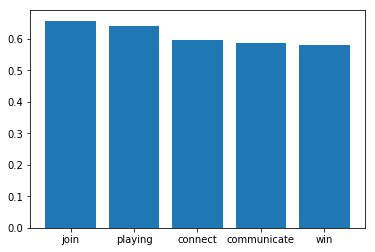

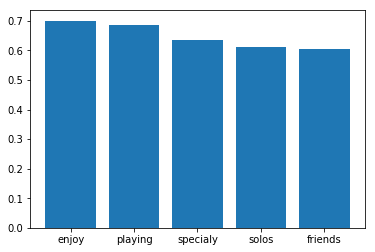

In [6]:
# Similarity check to find the better word weights matrix
vm_bar_chart('play',doc_model)
vm_bar_chart('play',wv_model)

In [8]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

def cnn_model(FILTER_SIZES, MAX_NB_WORDS, MAX_DOC_LEN, EMBEDDING_DIM,\
              train, test, label_train, label_test,\
              NUM_FILTERS=64, 
              DROP_OUT=0.5, 
              NUM_OUTPUT_UNITS=1, 
              NUM_DENSE_UNITS=100,
              PRETRAINED_WORD_VECTOR=None,
              LAM=0.0):
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        # use pretrained word vectors
                        weights=[PRETRAINED_WORD_VECTOR],\
                        # word vectors can be further tuned
                        trainable=True,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)
    
    if len(conv_blocks)>1:
        z=Concatenate(name='concate')(conv_blocks)
    else:
        z=conv_blocks[0]
        
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(NUM_DENSE_UNITS, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')

    BEST_MODEL_FILEPATH="best_model"
    checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', \
                             verbose=0, save_best_only=True, mode='min')
    
    training=model.fit(X_train, y_train, \
                       batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
                       callbacks=[earlyStopping,checkpoint],\
                       validation_data=[X_test, y_test], verbose=2)
    model.load_weights("best_model")

    pred=model.predict(X_test)

    pred=np.where(pred>0.5, 1, 0)

    print(classification_report(y_test, pred))
    return training

In [11]:
# Classification on labeled data
# load the labeled reviews
df_train = pd.read_csv('steam_reviews.csv')
df_train['user_reviews'] = df_train['user_reviews'].apply(\
                        lambda row: ' '.join(re.split(r'\W+', row)).strip(' '))
df_train['label'] = df_train['recommended or not'].replace({'Recommended': 1, 'Not Recommended': 0})
 
MAX_NB_WORDS=3585
MAX_DOC_LEN=100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_train["user_reviews"])
sequences = tokenizer.texts_to_sequences(df_train["user_reviews"])

padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')

NUM_WORDS = min(MAX_NB_WORDS, len(tokenizer.word_index))
embedding_matrix = np.zeros((NUM_WORDS+1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= NUM_WORDS:
        continue
    if word in doc_model.wv:
        embedding_matrix[i]=doc_model.wv[word]

X_train, X_test, y_train, y_test = train_test_split(\
                        padded_sequences, np_utils.to_categorical(df_train['label'], num_classes=2),\
                        test_size=0.3, random_state=1)

In [12]:
# Hyperparameter select
# plot the words frequency in reviews
def word_count_freq(tokenizer):
    df=pd.DataFrame.from_dict(tokenizer.word_counts, orient="index")
    df.columns = ['freq']
    print(df.head())
    df=df['freq'].value_counts().reset_index()
    df.columns=['word_freq','count']

    df=df.sort_values(by='word_freq')
    df['percent']=df['count']/len(tokenizer.word_counts)
    df['cumsum']=df['percent'].cumsum()
    print(df.head())
    df.iloc[0:50].plot(x='word_freq', y='cumsum');
    plt.show();
    
# plot the sequences(reviews in df) lenth
def sen_len(seq):
    sen_len=pd.Series([len(item) for item in seq])
    df=sen_len.value_counts().reset_index().sort_values(by='index')
    df.columns=['sent_length','counts']
    df['percent']=df['counts']/len(sen_len)
    df['cumsum']=df['percent'].cumsum()
    print(df.head(3))
    df.plot(x="sent_length", y='cumsum');
    plt.show();

           freq
pubg        215
corp         11
initiated     1
their        46
fix         110
   word_freq  count   percent    cumsum
0          1   1643  0.458298  0.458298
1          2    679  0.189400  0.647699
2          3    256  0.071409  0.719107
3          4    175  0.048815  0.767922
4          5    129  0.035983  0.803905


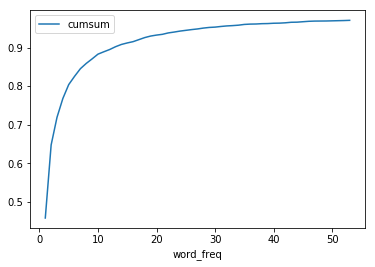

    sent_length  counts   percent    cumsum
10            0      61  0.029187  0.029187
1             1     216  0.103349  0.132536
0             2     228  0.109091  0.241627


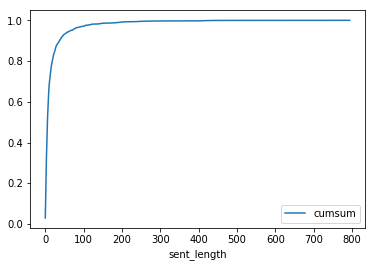

In [13]:
word_count_freq(tokenizer)
sen_len(sequences)

In [14]:
MAX_NB_WORDS=3585
MAX_DOC_LEN=100
FILTER_SIZES=[2,3,4]
output_units_num=2
num_filters= 64
dense_units_num = num_filters*len(FILTER_SIZES)
BTACH_SIZE = 8
NUM_EPOCHES = 100

print('Model generated without pretrained matrix:\n')
model_cnn = cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, \
                NUM_FILTERS=num_filters,\
                EMBEDDING_DIM = EMBEDDING_DIM,
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_DENSE_UNITS=dense_units_num,\
                train=X_train, label_train=y_train, test=X_test, label_test=y_test)

print('Model generated with pretrained matrix:\n')
model_doc2vec = cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, \
                NUM_FILTERS=num_filters,\
                EMBEDDING_DIM = EMBEDDING_DIM,
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_DENSE_UNITS=dense_units_num,\
                PRETRAINED_WORD_VECTOR=embedding_matrix,\
                train=X_train, label_train=y_train, test=X_test, label_test=y_test)

Model generated without pretrained matrix:

Train on 1463 samples, validate on 627 samples
Epoch 1/100
 - 2s - loss: 0.4830 - acc: 0.8165 - val_loss: 0.4910 - val_acc: 0.7799
Epoch 2/100
 - 1s - loss: 0.3617 - acc: 0.8414 - val_loss: 0.3404 - val_acc: 0.8517
Epoch 3/100
 - 1s - loss: 0.1970 - acc: 0.9224 - val_loss: 0.3307 - val_acc: 0.8692
Epoch 4/100
 - 1s - loss: 0.1042 - acc: 0.9648 - val_loss: 0.3758 - val_acc: 0.8676
Epoch 00004: early stopping
             precision    recall  f1-score   support

          0       0.77      0.57      0.66       138
          1       0.89      0.95      0.92       489

avg / total       0.87      0.87      0.86       627

Model generated with pretrained matrix:

Train on 1463 samples, validate on 627 samples
Epoch 1/100
 - 2s - loss: 0.5891 - acc: 0.7714 - val_loss: 0.4060 - val_acc: 0.8238
Epoch 2/100
 - 1s - loss: 0.4119 - acc: 0.8332 - val_loss: 0.3833 - val_acc: 0.8222
Epoch 3/100
 - 2s - loss: 0.3685 - acc: 0.8510 - val_loss: 0.3359 - val_ac

In [15]:
def results_plot(train):
    df=pd.DataFrame.from_dict(train.history)
    df.columns=["val_loss", "val_acc", \
                "train_loss", "train_acc"]
    df.index.name='epoch'
    print(df)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
    df[["train_acc", "val_acc"]].plot(ax=axes[0]);
    df[["train_loss", "val_loss"]].plot(ax=axes[1]);
    plt.show();

       val_loss   val_acc  train_loss  train_acc
epoch                                           
0      0.491019  0.779904    0.482970   0.816473
1      0.340432  0.851675    0.361726   0.841422
2      0.330736  0.869219    0.197025   0.922420
3      0.375842  0.867624    0.104192   0.964798


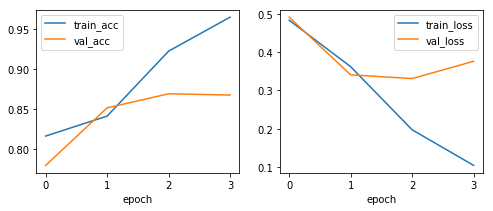

       val_loss   val_acc  train_loss  train_acc
epoch                                           
0      0.406011  0.823764    0.589092   0.771360
1      0.383253  0.822169    0.411907   0.833219
2      0.335873  0.860447    0.368466   0.850991
3      0.313707  0.870813    0.298103   0.880383
4      0.305618  0.881978    0.245211   0.899180
5      0.304285  0.888357    0.237096   0.908407
6      0.292384  0.901914    0.174957   0.928913
7      0.294899  0.894737    0.187612   0.927546


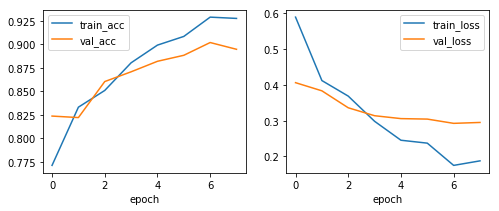

In [16]:
results_plot(model_cnn)
results_plot(model_doc2vec)